## Project Goal

The objective of this project is to apply unsupervised learning techniques to a social media user dataset to identify distinct user groups (personas) based on their behavior. The ultimate goal is to provide data-driven strategic support for the platform's user operations, feature development, and community management.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [2]:
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["axes.unicode_minus"] = False

In [3]:
# Load the dataset
file_path = "/Users/macbook/Library/CloudStorage/OneDrive-UniversityofBath/PGcourses/DL & ML/dataset_1.csv"
df = pd.read_csv(file_path)
df_orig = df.copy()
df = df.set_index("ID")
df.head()

,TotalReplies,TotalResponses,TotalPosts,AverageWordsPerPost,LikeRate,QuestionsAsked,URLSharing,MeanPostsPerThread,ConversationInitiationRate,PostingDiversity,BidirectionalNetwork
ID,,,,,,,,,,,
0,53,54,83,63.0,0.759036,0.325301,0.072289,1.596154,0.192308,9.222222,0.289157
1,25,25,67,151.0,0.089552,0.104478,0.074627,2.913043,0.826087,67.000000,0.351351
2,4,3,4,65.0,0.250000,0.000000,0.000000,2.000000,0.500000,2.000000,0.000000
3,79,84,191,33.0,0.837696,0.157068,0.036649,1.929293,0.111111,14.692308,0.405172
4,2,3,3,25.0,0.000000,0.333333,0.000000,1.000000,0.000000,1.500000,0.250000


In [4]:
# Display basic information about the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2307 entries, 0 to 2306
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   TotalReplies                2307 non-null   int64  
 1   TotalResponses              2307 non-null   int64  
 2   TotalPosts                  2307 non-null   int64  
 3   AverageWordsPerPost         2307 non-null   float64
 4   LikeRate                    2307 non-null   float64
 5   QuestionsAsked              2307 non-null   float64
 6   URLSharing                  2307 non-null   float64
 7   MeanPostsPerThread          2307 non-null   float64
 8   ConversationInitiationRate  2307 non-null   float64
 9   PostingDiversity            2307 non-null   float64
 10  BidirectionalNetwork        2307 non-null   float64
dtypes: float64(8), int64(3)
memory usage: 216.3 KB


In [5]:
# Display descriptive statistics
df.describe()

,TotalReplies,TotalResponses,TotalPosts,AverageWordsPerPost,LikeRate,QuestionsAsked,URLSharing,MeanPostsPerThread,ConversationInitiationRate,PostingDiversity,BidirectionalNetwork
count,2307.000000,2307.000000,2307.000000,2307.000000,2307.000000,2307.000000,2307.000000,2307.000000,2307.000000,2307.000000,2307.000000
mean,36.319029,39.357174,79.699610,114.691844,0.587254,0.295906,0.068508,2.201240,0.229689,9.949544,0.238960
std,57.810106,67.614166,182.971141,149.647263,0.773175,0.235612,0.154455,3.494756,0.306419,24.275245,0.197268
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
25%,3.000000,3.000000,4.000000,45.124250,0.083333,0.129320,0.000000,1.189577,0.000000,2.000000,0.083333
50%,11.000000,10.000000,14.000000,75.153800,0.412651,0.274510,0.000000,1.595238,0.093023,4.000000,0.232558
75%,42.000000,43.000000,63.000000,132.000000,0.833333,0.416667,0.063733,2.200000,0.333333,9.500000,0.350676
max,416.000000,571.000000,1835.000000,3118.000000,16.000000,1.000000,1.000000,87.000000,2.000000,623.000000,1.000000


# Exploratory Data Analysis (EDA) & Findings

Prior to modeling, an exploratory analysis was conducted, leading to two key findings that dictated our subsequent data preprocessing and modeling methodologies:

1.  **Severe Right-Skewed Data Distribution:**
    * **Observation:** Histograms revealed that most variables, especially count-based ones like `TotalPosts` and `TotalReplies`, contained a few extreme high values.
    * **Implication:** Such outliers can disproportionately influence distance-based clustering algorithms like K-Means, causing the model to focus almost exclusively on these "power users" while ignoring the nuances among the majority.
    * **Solution:** Employ a **logarithmic transformation (`log1p`)** to compress the data's scale, thereby reducing the impact of extreme values and allowing for a more equitable comparison across all users.

2.  **High Correlation Between Features (Multicollinearity):**
    * **Observation:** The correlation matrix heatmap showed strong positive correlations (coefficient > 0.8) between variables like `TotalPosts`, `TotalReplies`, and `TotalResponses`.
    * **Implication:** This suggests these variables are measuring the same underlying concept (e.g., "overall activity"). Including all of them directly in the model would introduce redundancy and could cause the model to overweight this single concept, overshadowing other valuable dimensions.
    * **Solution:** Use **Principal Component Analysis (PCA)** for feature engineering. PCA consolidates these correlated features into a new set of linearly uncorrelated principal components, eliminating redundancy while preserving the maximum possible information from the original dataset.


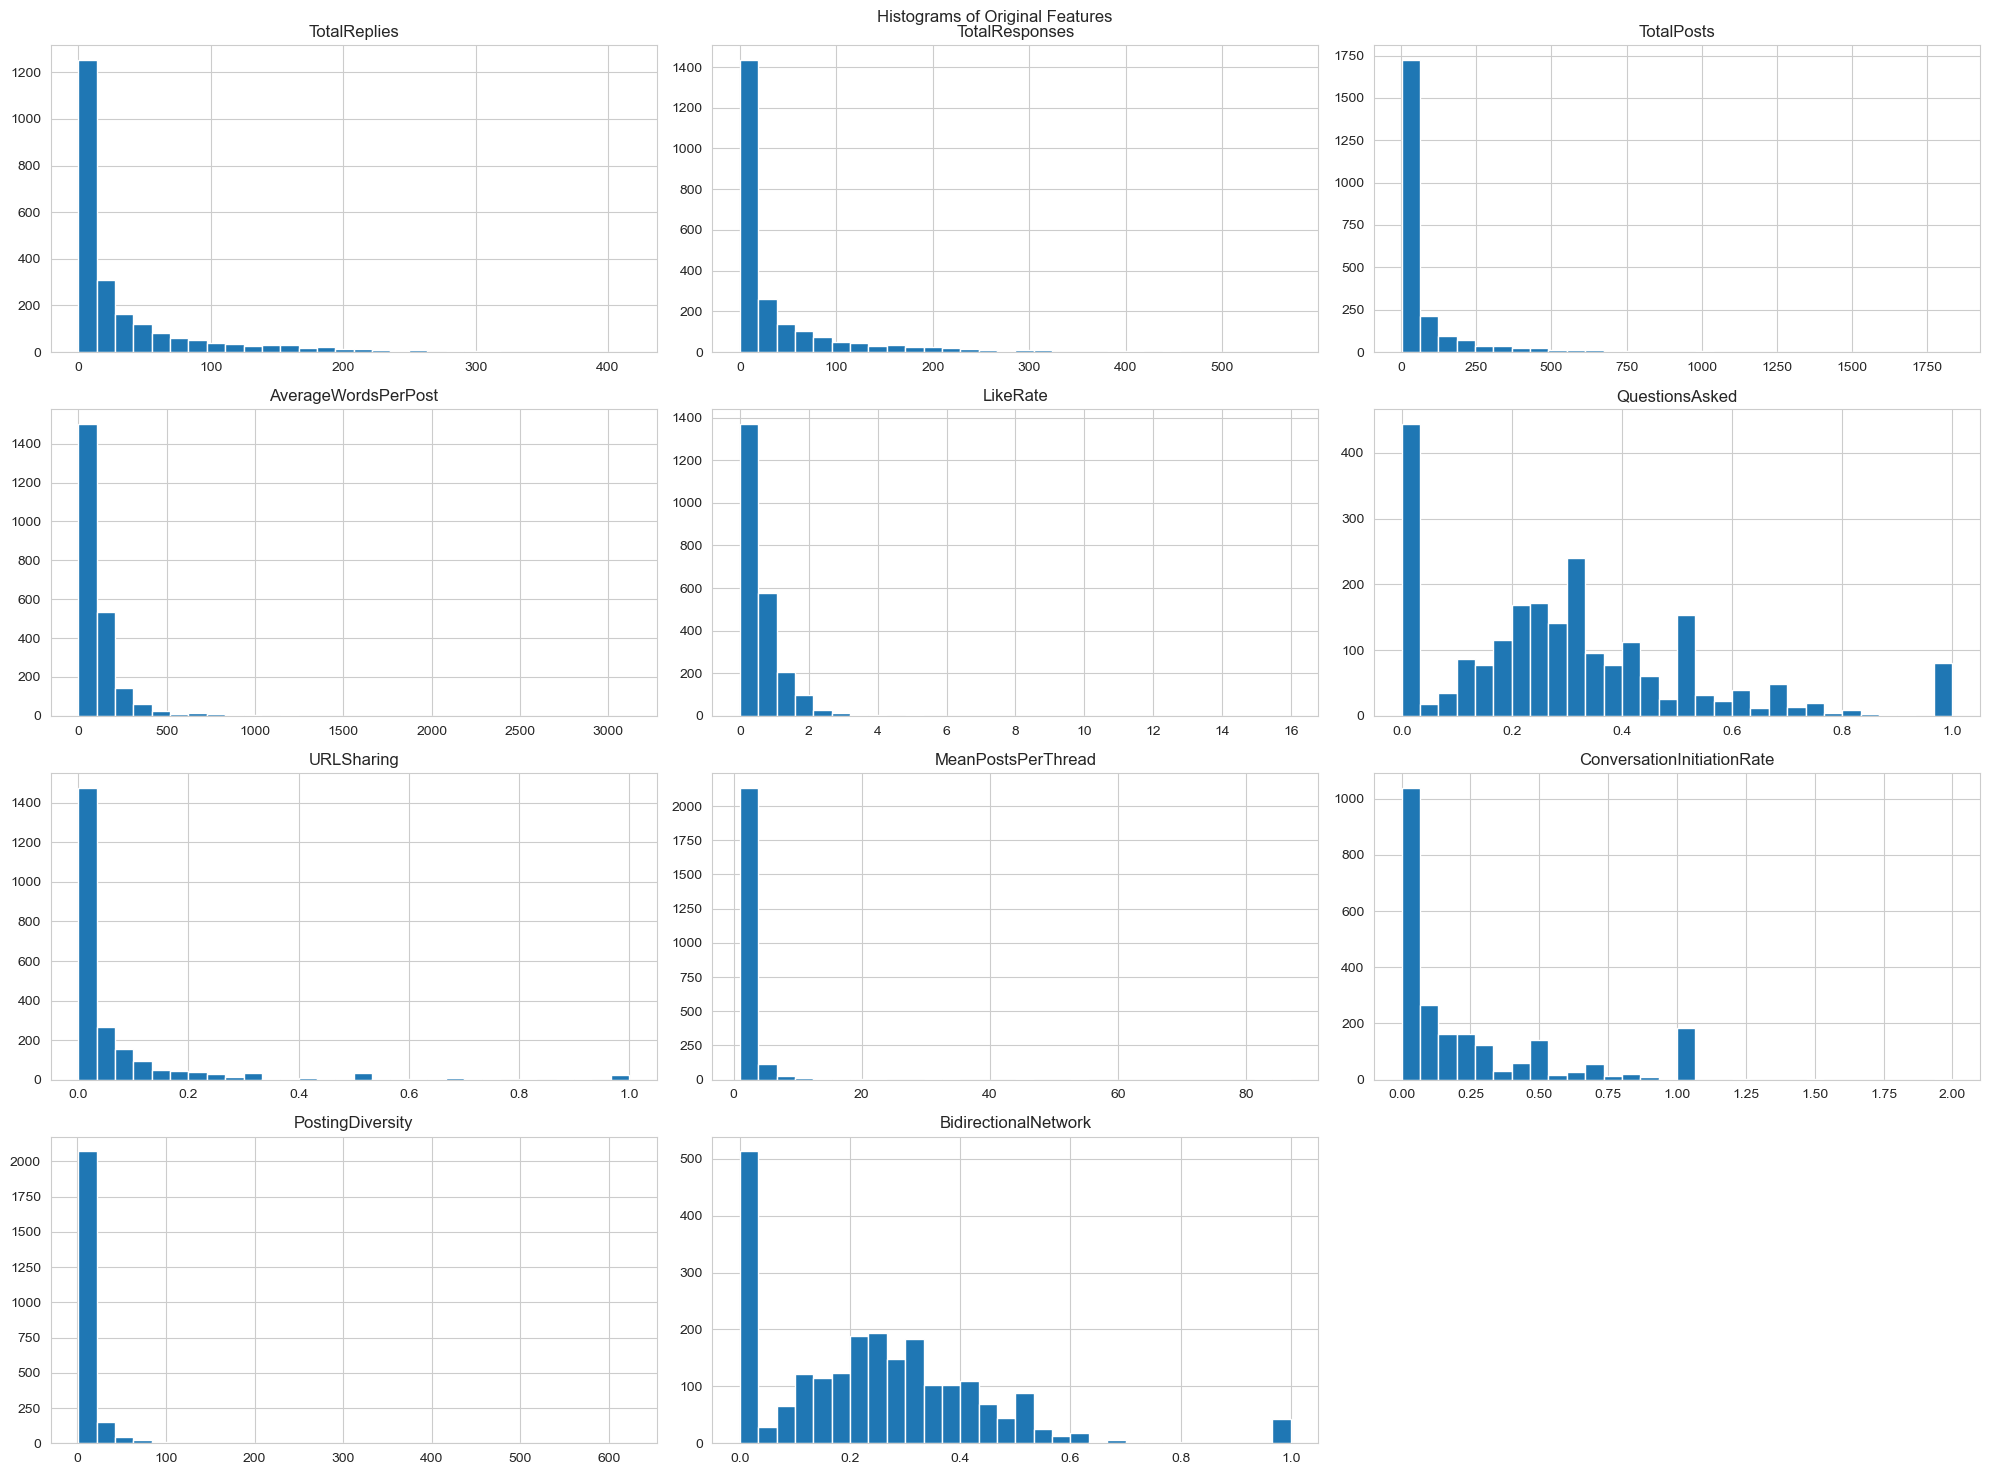

In [6]:
# Plot histograms for each feature to check distributions
df.hist(bins=30, figsize=(20, 15))
plt.suptitle("Histograms of Original Features")
plt.tight_layout()
plt.show()

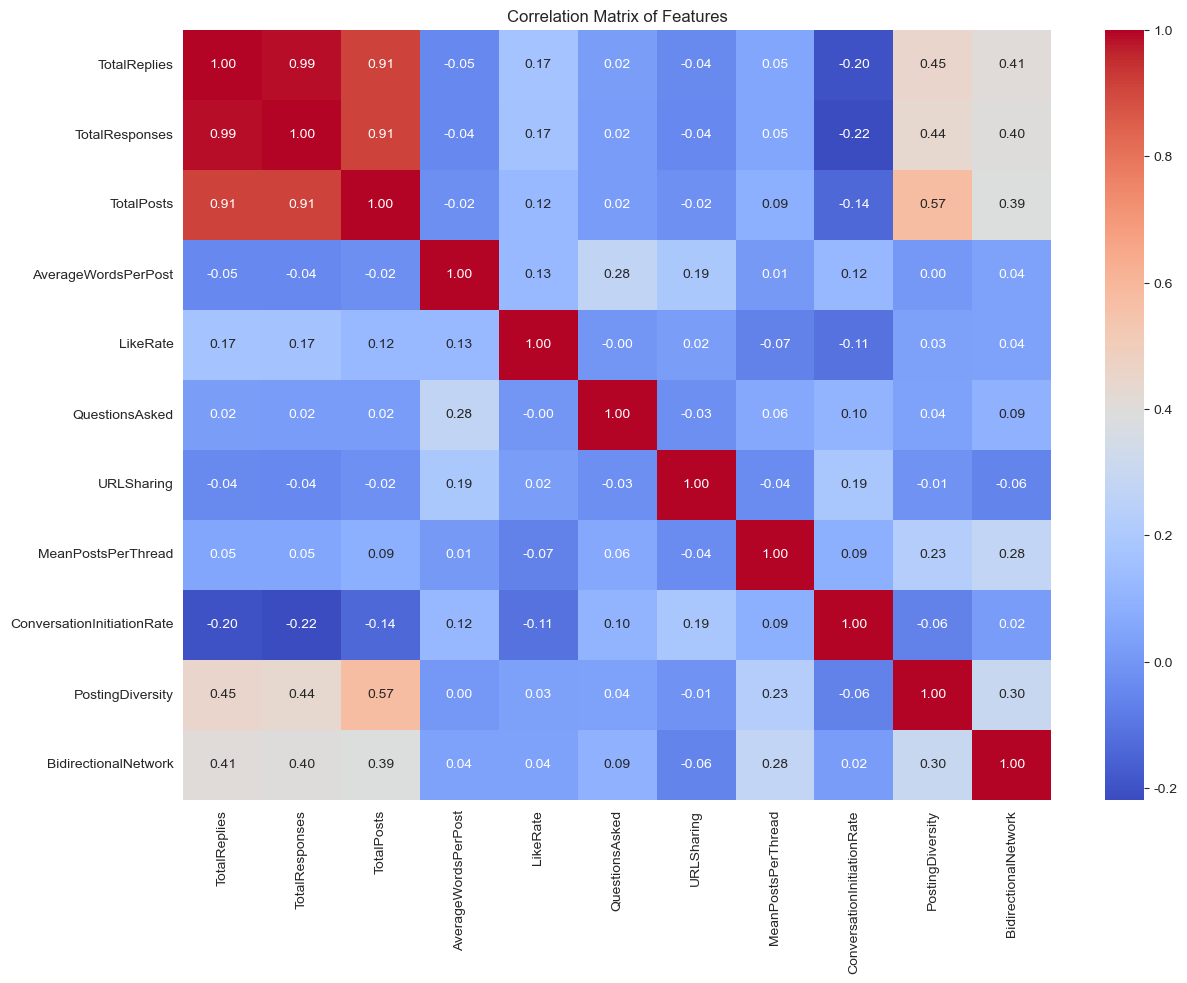

In [7]:
# Visualize the correlation matrix
plt.figure(figsize=(14, 10))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Features")
plt.show()

# Modeling Methodology and Selection

Based on the EDA findings, our modeling pipeline was as follows:

1.  **Data Preprocessing:** Apply a log transform to the raw data, followed by standardization (StandardScaler).
2.  **Feature Engineering:** Apply PCA to the preprocessed data, reducing the original 11 features. We chose the number of components required to explain **over 90% of the variance** (determined to be 7) to form our new feature space.
3.  **Model Selection and Comparison:** Run the K-Means clustering algorithm on the new PCA-reduced data. We focused our analysis on comparing the two most promising options for the number of clusters: `k=2` and `k=3`.


## Data Preprocessing

In [8]:
# Apply log transformation to reduce skewness. We use log1p to handle zeros.
df_log = df.apply(np.log1p)

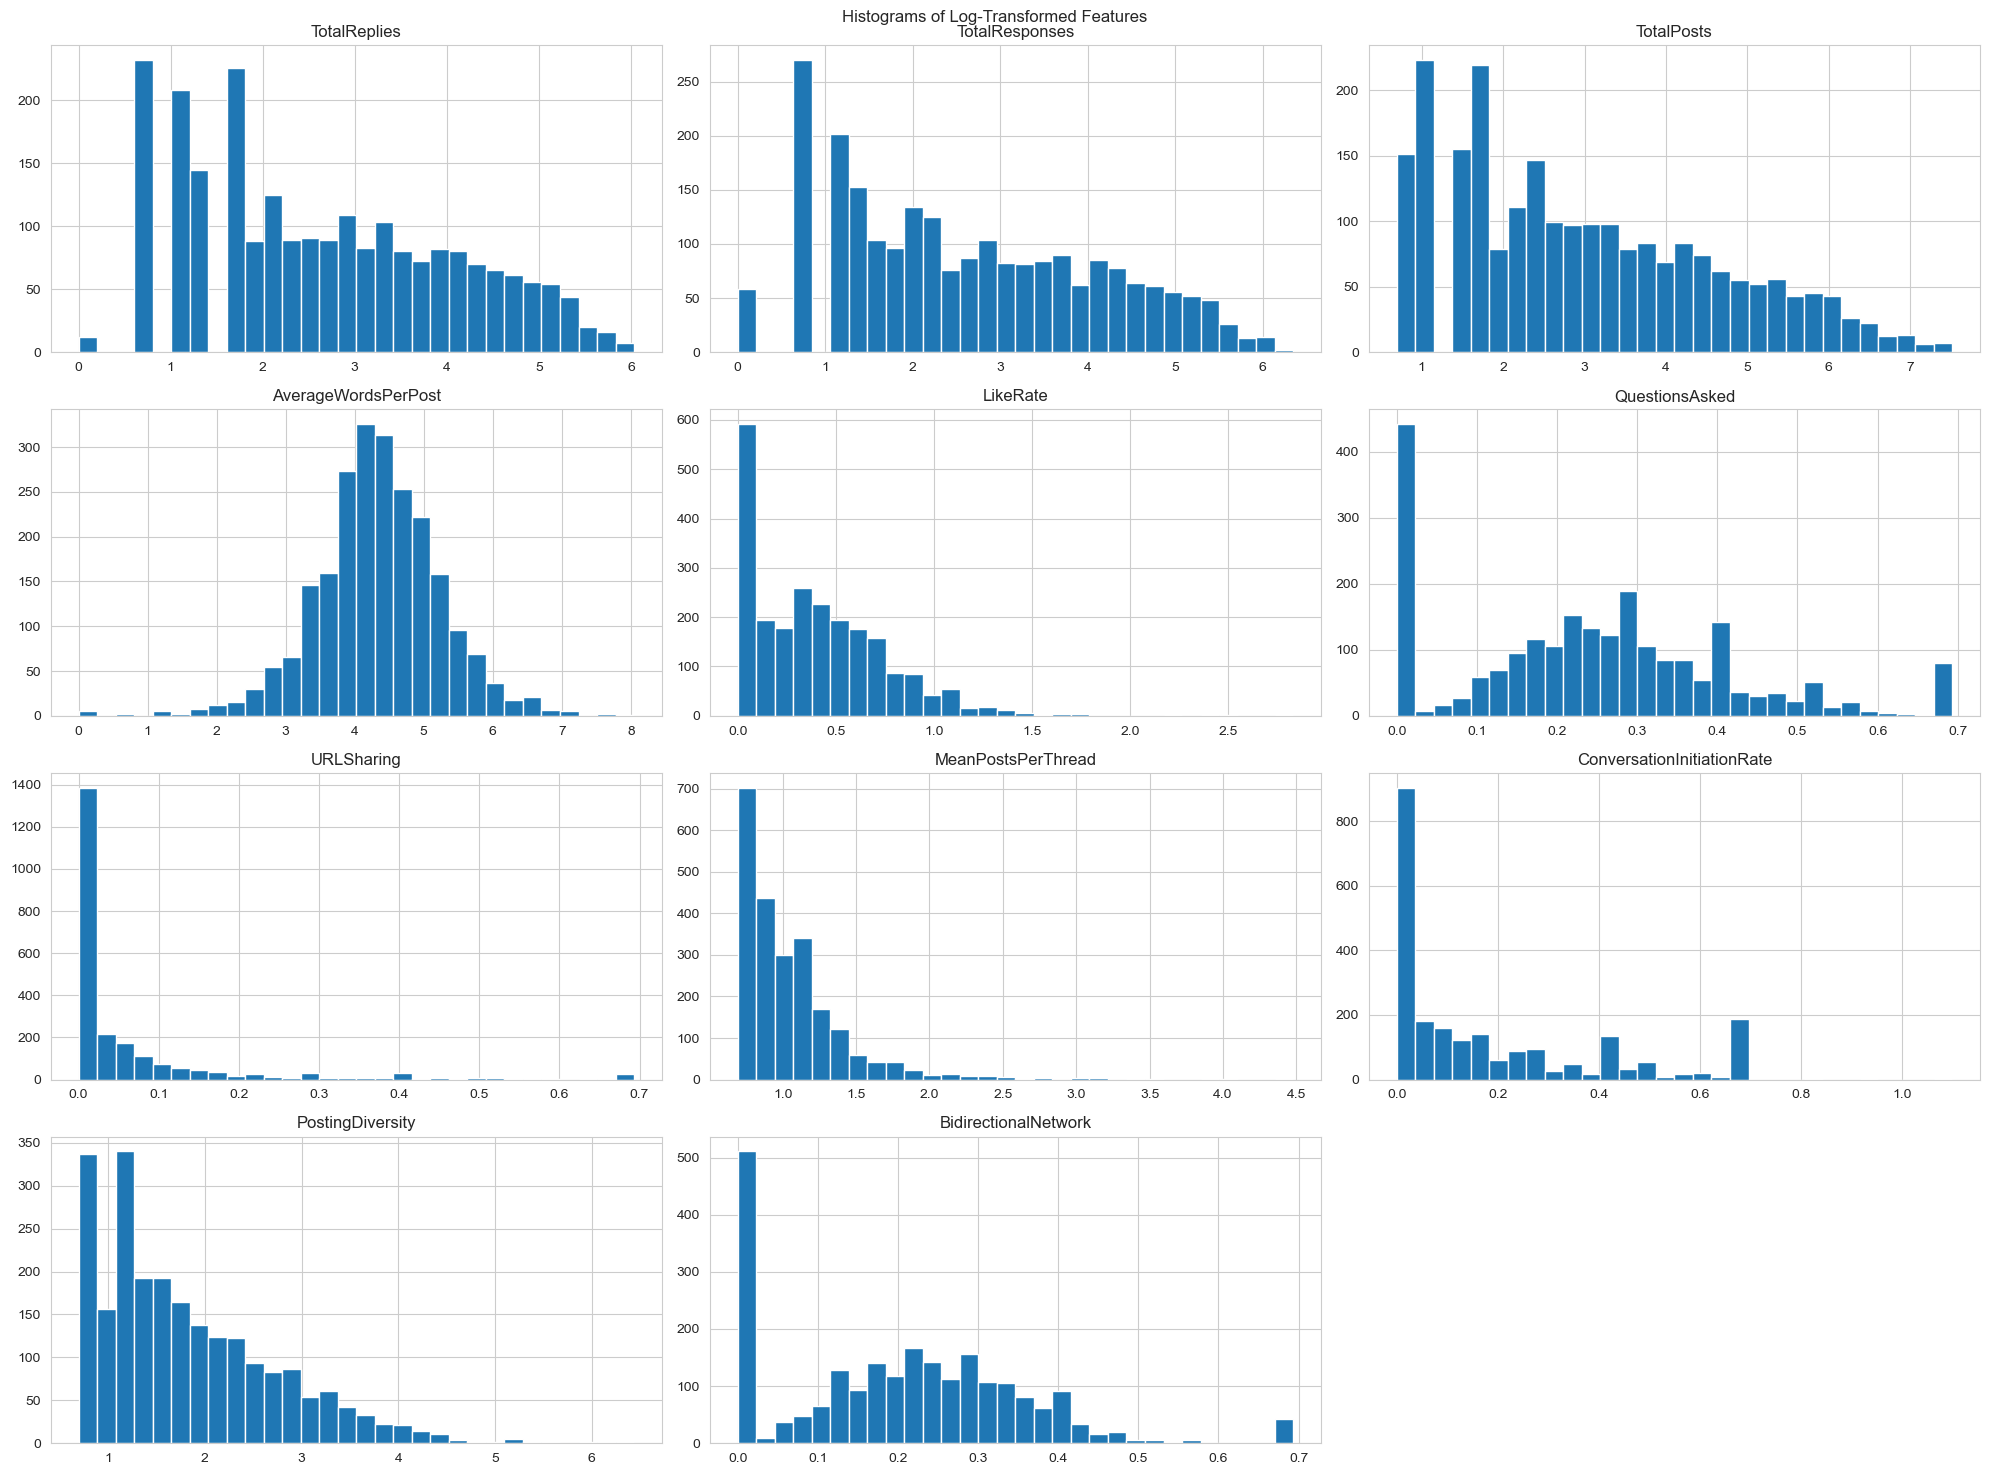

In [9]:
# Plot histograms of the log-transformed data
df_log.hist(bins=30, figsize=(20, 15))
plt.suptitle("Histograms of Log-Transformed Features")
plt.tight_layout()
plt.show()

In [10]:
# Standardize the log-transformed data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_log)
df_scaled = pd.DataFrame(df_scaled, index=df_log.index, columns=df_log.columns)

## Feature Engineering with Principal Component Analysis (PCA)

In [11]:
# Determine the number of components to capture >90% of variance
pca_explainer = PCA(n_components=None, random_state=42)
pca_explainer.fit(df_scaled)
n_components = np.argmax(np.cumsum(pca_explainer.explained_variance_ratio_) >= 0.9) + 1
print(f"Number of components to capture >90% variance: {n_components}")

Number of components to capture >90% variance: 7


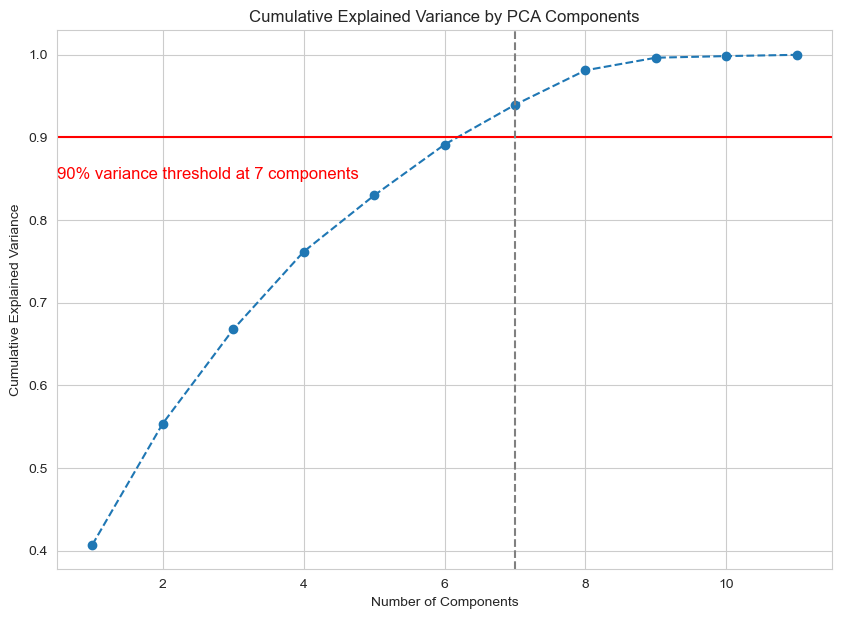

In [12]:
# Plot the cumulative explained variance
plt.figure(figsize=(10, 7))
plt.plot(
    range(1, len(pca_explainer.explained_variance_ratio_) + 1),
    np.cumsum(pca_explainer.explained_variance_ratio_),
    marker="o",
    linestyle="--",
)
plt.title("Cumulative Explained Variance by PCA Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.axhline(y=0.9, color="r", linestyle="-")
plt.axvline(x=n_components, color="grey", linestyle="--")
plt.text(
    0.5,
    0.85,
    f"90% variance threshold at {n_components} components",
    color="red",
    fontsize=12,
)
plt.show()

We can see that ~7 components explain 90% of the variance. We will use these 7 components for our new model.

In [20]:
pca = PCA(n_components=n_components, random_state=42)
df_pca = pca.fit_transform(df_scaled)
df_pca = pd.DataFrame(
    df_pca, columns=[f"PC{i+1}" for i in range(n_components)], index=df_scaled.index
)

## Model Selection

In [21]:
# Determine optimal k for the PCA-transformed data
wcss_pca = []
silhouette_scores_pca = []
k_range = range(2, 11)
for i in k_range:
    kmeans = KMeans(n_clusters=i, init="k-means++", random_state=42, n_init="auto")
    kmeans.fit(df_pca)
    wcss_pca.append(kmeans.inertia_)
    silhouette_scores_pca.append(silhouette_score(df_pca, kmeans.labels_))

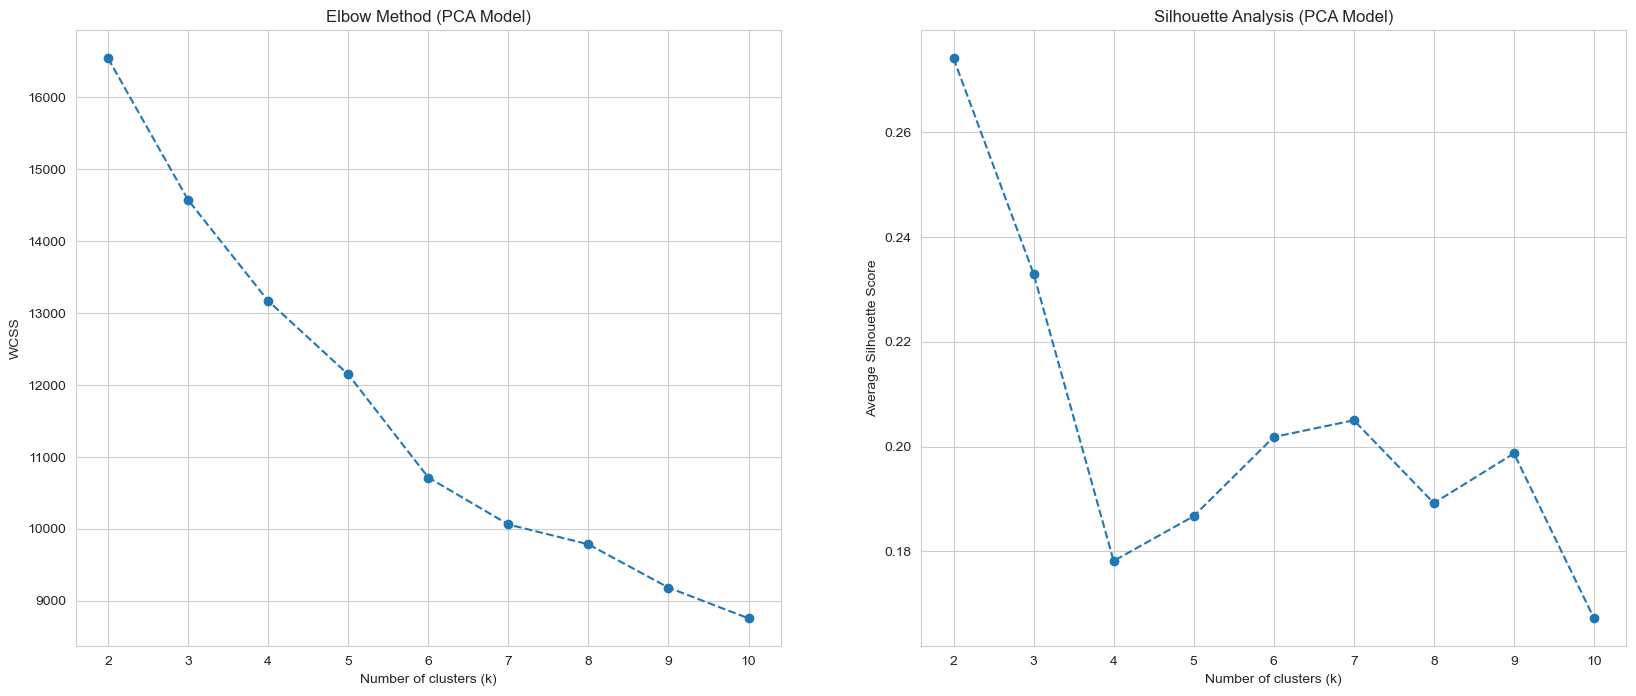

In [22]:
# Plot Elbow and Silhouette for the PCA data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
ax1.plot(k_range, wcss_pca, marker="o", linestyle="--")
ax1.set_title("Elbow Method (PCA Model)")
ax1.set_xlabel("Number of clusters (k)")
ax1.set_ylabel("WCSS")
ax1.set_xticks(k_range)

ax2.plot(k_range, silhouette_scores_pca, marker="o", linestyle="--")
ax2.set_title("Silhouette Analysis (PCA Model)")
ax2.set_xlabel("Number of clusters (k)")
ax2.set_ylabel("Average Silhouette Score")
ax2.set_xticks(k_range)
plt.show()

The Silhouette Analysis clearly shows k=2 as the statistically optimal choice, with the highest score. However, k=3 also presents a locally high score before a sharp drop, suggesting it might also be a valid structure. We will explore both.

In [23]:
# Train both k=2 and k=3 models
kmeans_k2 = KMeans(n_clusters=2, init="k-means++", random_state=42, n_init="auto")
kmeans_k3 = KMeans(n_clusters=3, init="k-means++", random_state=42, n_init="auto")

df_orig["Cluster_k2"] = kmeans_k2.fit_predict(df_pca)
df_orig["Cluster_k3"] = kmeans_k3.fit_predict(df_pca)

In [27]:
# Analysis and Comparison
centroids_k2 = df_orig.groupby("Cluster_k2")[df.columns].mean()
centroids_k3 = df_orig.groupby("Cluster_k3")[df.columns].mean()

print("\n--- Centroids for k=2 Model ---")
centroids_k2


--- Centroids for k=2 Model ---


,TotalReplies,TotalResponses,TotalPosts,AverageWordsPerPost,LikeRate,QuestionsAsked,URLSharing,MeanPostsPerThread,ConversationInitiationRate,PostingDiversity,BidirectionalNetwork
Cluster_k2,,,,,,,,,,,
0,6.294031,5.575534,7.368460,114.782955,0.492590,0.282694,0.076458,1.595129,0.286438,2.781424,0.165565
1,79.207368,87.611579,183.018947,114.561700,0.722475,0.314780,0.057152,3.067021,0.148629,20.188638,0.343800


In [26]:
print("\n--- Centroids for k=3 Model ---")
centroids_k3


--- Centroids for k=3 Model ---


,TotalReplies,TotalResponses,TotalPosts,AverageWordsPerPost,LikeRate,QuestionsAsked,URLSharing,MeanPostsPerThread,ConversationInitiationRate,PostingDiversity,BidirectionalNetwork
Cluster_k3,,,,,,,,,,,
0,6.093470,5.852753,6.851472,61.738910,0.519948,0.152379,0.055137,1.282384,0.145590,2.300111,0.104241
1,8.283843,6.803493,10.848617,187.681558,0.462253,0.450625,0.102995,2.354430,0.460166,4.438791,0.260159
2,87.411204,97.201430,203.889154,104.217838,0.752262,0.302823,0.052716,2.931138,0.119253,21.582554,0.347009


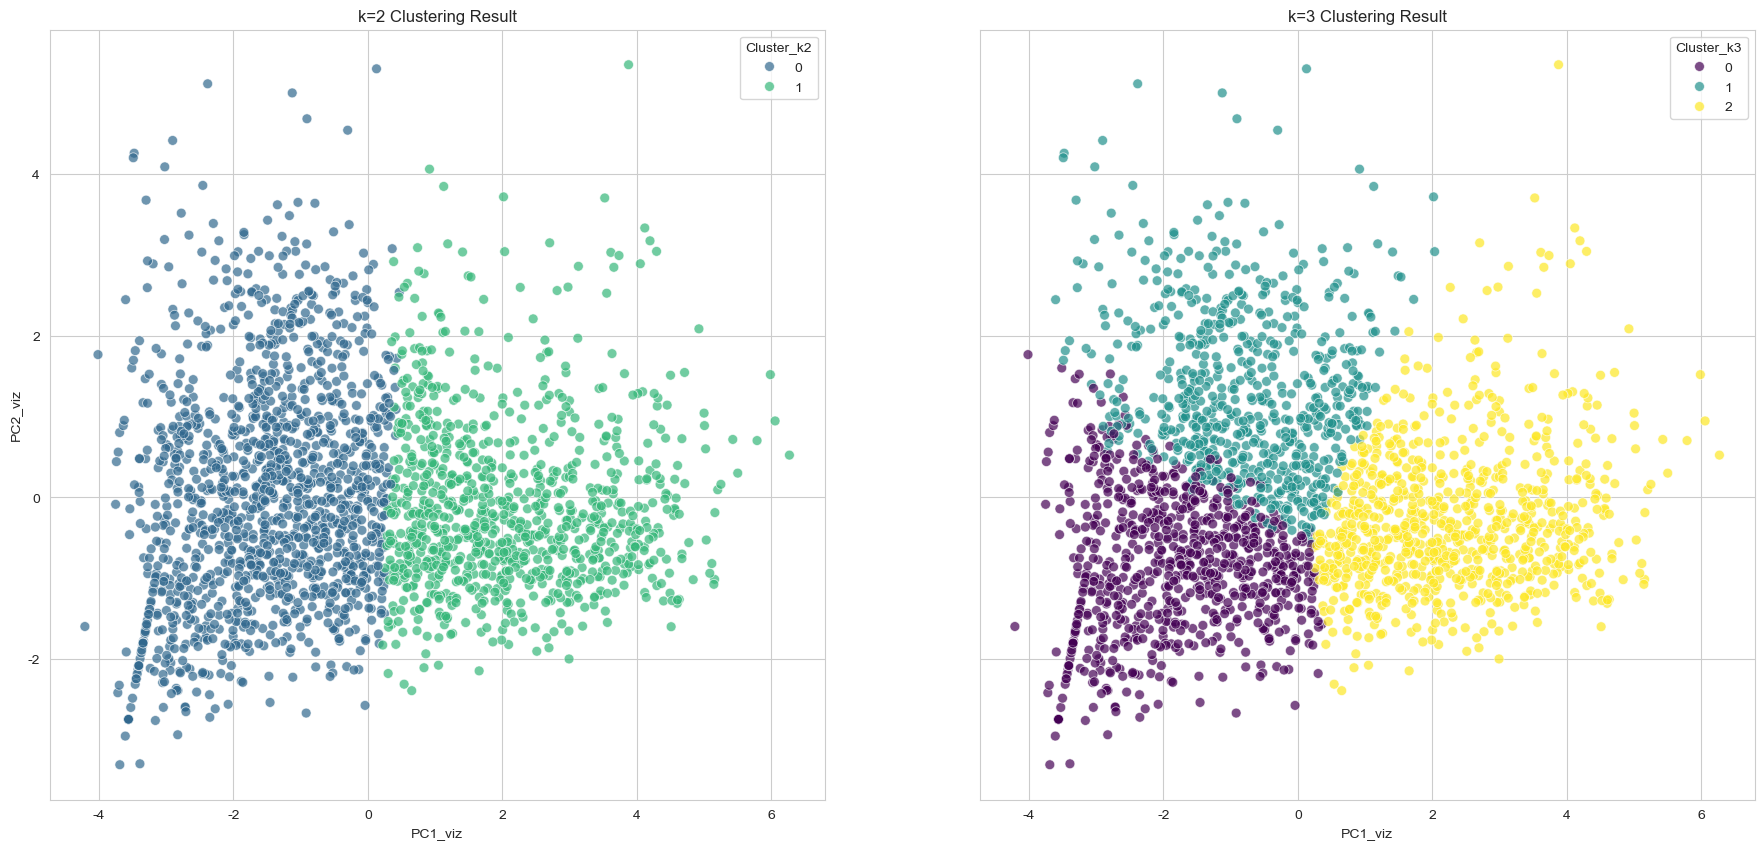

In [28]:
# Visualize both clustering results
pca_viz = PCA(n_components=2, random_state=42)
df_viz = pca_viz.fit_transform(df_scaled)
df_viz = pd.DataFrame(df_viz, columns=["PC1_viz", "PC2_viz"])
df_viz["Cluster_k2"] = df_orig["Cluster_k2"].values
df_viz["Cluster_k3"] = df_orig["Cluster_k3"].values

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 10), sharey=True)
sns.scatterplot(
    x="PC1_viz",
    y="PC2_viz",
    hue="Cluster_k2",
    data=df_viz,
    palette="viridis",
    s=50,
    alpha=0.7,
    ax=ax1,
)
ax1.set_title("k=2 Clustering Result")

sns.scatterplot(
    x="PC1_viz",
    y="PC2_viz",
    hue="Cluster_k3",
    data=df_viz,
    palette="viridis",
    s=50,
    alpha=0.7,
    ax=ax2,
)
ax2.set_title("k=3 Clustering Result")
plt.show()

### Why Was k=3 Ultimately Chosen?

This decision represents a classic trade-off between statistical optimality and business utility.

* **`k=2` (The Statistically Optimal Choice):**
    * The Silhouette Analysis gave `k=2` the highest score, indicating that from a purely mathematical standpoint, the data's most natural structure is two distinct groups.
    * However, these two groups merely represent a simple binary split of **"high-activity users"** vs. **"low-activity users."** While correct, this insight is too broad to be highly actionable for business operations.

* **`k=3` (The Business-Optimal Choice):**
    * Although `k=3` had a slightly lower silhouette score than `k=2`, it provided far superior business insight.
    * It successfully segmented the broad "high-activity" group into two distinct, and highly valuable, personas: the **"Thought Leaders"** and the **"Super Contributors."**
    * This distinction is crucial. For instance, a platform might use one strategy (e.g., monetization, traffic boosting) to incentivize "Thought Leaders" to create deep content, and a different strategy (e.g., community honors, moderation tools) to encourage "Super Contributors" to maintain the community. The `k=2` model cannot provide the basis for such targeted actions.

**Final Decision:**
We selected `k=3` as our final model. This is a conscious decision to **accept a minor compromise on a statistical metric in exchange for deeper, more actionable business insights.** In applied data science, models ultimately serve business objectives, making a choice guided by interpretability and utility both reasonable and desirable.



In [31]:
# Final choice
print("\n--- Final Model: k=3 Cluster Sizes ---")
print(df_orig["Cluster_k3"].value_counts())

print("\n--- Final Model: k=3 Centroids ---")
centroids_k3


--- Final Model: k=3 Cluster Sizes ---
Cluster_k3
2    839
0    781
1    687
Name: count, dtype: int64

--- Final Model: k=3 Centroids ---


,TotalReplies,TotalResponses,TotalPosts,AverageWordsPerPost,LikeRate,QuestionsAsked,URLSharing,MeanPostsPerThread,ConversationInitiationRate,PostingDiversity,BidirectionalNetwork
Cluster_k3,,,,,,,,,,,
0,6.093470,5.852753,6.851472,61.738910,0.519948,0.152379,0.055137,1.282384,0.145590,2.300111,0.104241
1,8.283843,6.803493,10.848617,187.681558,0.462253,0.450625,0.102995,2.354430,0.460166,4.438791,0.260159
2,87.411204,97.201430,203.889154,104.217838,0.752262,0.302823,0.052716,2.931138,0.119253,21.582554,0.347009


# Conclusion and User Persona Interpretation

Based on the `k=3` clustering results, we define the following three core user personas:

- Persona 1: The Everyday Participants
  * **Characteristics:** The largest group, with low to moderate scores on all metrics. They represent the general user base engaging in casual, light interaction.
  * **Value:** They form the platform's foundational activity and audience, acting as the primary consumers for content created by the other two groups.

- Persona 2: The Thought Leaders / Niche Authors
  - **Characteristics:** Distinguished by the highest `AverageWordsPerPost`, `QuestionsAsked`, and `ConversationInitiationRate`. They don't post a high volume, but their content is deep, thought-provoking, and initiates new discussions.
  - **Value:** They are the source of the platform's intellectual depth and content quality, acting as the "igniters" for new topics and community vitality.

- Persona 3: The Super Contributors
  - **Characteristics:** The platform's powerhouse. They lead in almost all volume-based metrics: `TotalPosts`, `TotalReplies`, `TotalResponses`, `PostingDiversity`, and `BidirectionalNetwork`.
  - **Value:** They are the core engine for both content production and the community's social network, crucial for sustaining the platform's ecosystem.

This analysis followed a rigorous process—from identifying issues in the EDA, to solving them with PCA and clustering, and finally to a nuanced trade-off analysis between competing models. This led to the selection of a `k=3` segmentation scheme. The three identified personas provide a clear, actionable framework for understanding the platform's ecosystem and enabling sophisticated, data-driven user management.